# Getting Started

This tutorial contains examples with increasing complexity to introduce you to the combigrid module.

The combigrid module is quite separated from the other modules. It only refers to the base module for things like DataVector and DataMatrix. At the beginning of the program, we have to import the pysgpp library. 

In [1]:
import pysgpp
from itertools import product, combinations, permutations,\
    combinations_with_replacement
from pysgpp.extensions.datadriven.uq.dists import J, Beta, Uniform
from pysgpp.extensions.datadriven.uq.plot.colors import initialize_plotting_style, \
    load_color, load_font_properties, savefig
from pysgpp.extensions.datadriven.uq.plot.plot3d import plotSG3d
import math
import pysgpp

from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
import numpy as np

The first thing we need is a function to evaluate. This function will be evaluated on the domain $[0,1]^d$. This particular function can be used with any number of dimensions. The input parameter of the function is of type pysgpp.DataVector, so do not treat it like a list. The return type is float. 

In [2]:
def f(x):
    product = 1.0
    for i in range(x.getSize()):
        product *= math.exp(-x[i])
    return product


def g(x):
    return np.prod([4 * xi * (1 - xi) for xi in x.array()])


## We have to wrap f in a pysgpp.MultiFunction object.
func = pysgpp.multiFunc(g)

Let's use a 3D-function for the first examples. 

In [3]:
d = 3

### Example 1: Leja quadrature with linear growth of grid points

Here comes the first and very simple example. 

In [4]:
def example1():
    # Let's increase the number of points by two for each level.
    growthFactor = 2
    # Now create the operation object that handles the evaluation. The evaluation mode is quadrature,
    # so it will approximate the integral of f over [0, 1]^d. It uses Leja points with 1 + 2*l
    # points in level l. The level starts from zero, higher level means finer grid.
    # Slower growth of the number of points per level means that the total number of points used can
    # be controlled better.
    operation = pysgpp.CombigridOperation.createLinearLejaQuadrature(d, func, growthFactor)
    # Now, we compute the result. The parameter 2 means that grid at level-multi-indices with a
    # 1-norm (i.e. sum of entries) less than or equal to 2 are used. In our 3D case, these are
    # exactly the levels (0, 0, 0), (1, 0, 0), (2, 0, 0), (1, 1, 0), (1, 0, 1), (0, 1, 0), (0, 2, 0),
    # (0, 1, 1), (0, 0, 1) and (0, 0, 2).
    result = operation.evaluate(2)
    # Now compare the result to the analytical solution:
    print("Quadrature result: " + str(result) + ", analytical solution: " + str(math.pow(1.0 - 1.0 / math.e, d)))
    # We can also find out how many function evaluations have been used by accessing the storage
    # which stores computed function values:
    print("Number of function evaluations: " + str(operation.numGridPoints()))
    
example1()

Quadrature result: 0.33333333333333504, analytical solution: 0.25258045782764715
Number of function evaluations: 25


### Example 2: Polynomial interpolation on nested Clenshaw Curtis grids

The next example uses interpolation. 

Interpolation result: 0.343535125553586, function value: 0.3435351255535862
Function evaluations: 69
Target function value: 0.6402216669222761
Regular result 1: 0.6402216669222761
Total function evaluations: 69
Regular result 2: 0.6402216669222767
Total function evaluations: 113
Adaptive result: 0.6402216669222754
Total function evaluations: 161


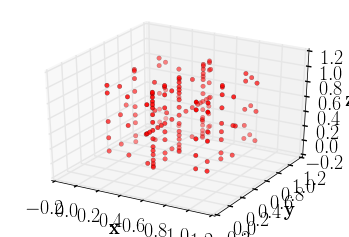

In [5]:
def example2():
    # This time, we use Clenshaw-Curtis points with exponentially growing number of points per level.
    # This is helpful for CC points to make them nested. Nested means that the set of grid points at
    # one level is a subset of the set of grid points at the next level. Nesting can drastically
    # reduce the number of needed function evaluations. Using these grid points, we will do
    # polynomial interpolation at a single point.
    #operation = pysgpp.CombigridOperation.createExpClenshawCurtisPolynomialInterpolation(d, func)
    operation = pysgpp.CombigridOperation.createExpL2LejaPolynomialInterpolation(d, func)
    # Now create a point where to evaluate the interpolated function:
    evaluationPoint = pysgpp.DataVector([0.1572, 0.6627, 0.2378])
    # We can now evaluate the interpolation at this point (using 3 as a bound for the 1-norm of the
    # level multi-index):
    result = operation.evaluate(3, evaluationPoint)
    # Now compare the result to the actual function value:
    print("Interpolation result: " + str(result) + ", function value: " + str(func(evaluationPoint)))
    # Again, print the number of function evaluations:
    print("Function evaluations: " + str(operation.numGridPoints()))
    # Now, let's do another (more sophisticated) evaluation at a different point, so change the point
    # and re-set the parameter. This method will automatically clear all intermediate values that
    # have been computed internally up to now.
    evaluationPoint[0] = 0.4444
    print("Target function value: " + str(func(evaluationPoint)))
    operation.setParameters(evaluationPoint)
    # The level manager provides more options for combigrid evaluation, so let's get it:
    levelManager = operation.getLevelManager()
    # We can add regular levels like before:
    levelManager.addRegularLevels(3)
    # The result can be fetched from the CombigridOperation:
    print("Regular result 1: " + str(operation.getResult()))
    print("Total function evaluations: " + str(operation.numGridPoints()))
    # We can also add more points in a regular structure, using at most 50 new function evaluations.
    # Most level-adding variants of levelManager also have a parallelized version. This version
    # executes the calls to func in parallel with a specified number of threads, which is okay here
    # since func supports parallel evaluations. Since func takes very little time to evaluate and the
    # parallelization only concerns function evaluations and not the computations on the resulting
    # function values, parallel evaluation is not actually useful in this case.
    # We will use 4 threads for the function evaluations.
    levelManager.addRegularLevelsByNumPointsParallel(50, 4)
    print("Regular result 2: " + str(operation.getResult()))
    print("Total function evaluations: " + str(operation.numGridPoints()))
    # We can also use adaptive level generation. The adaption strategy depends on the subclass of
    # LevelManager that is used. If you do not want to use the default LevelManager, you can specify
    # your own LevelManager:
    operation.setLevelManager(pysgpp.AveragingLevelManager())
    levelManager = operation.getLevelManager()
    # It was necessary to use setLevelManager(), because this links the LevelManager to the
    # computation. Now, let's add at most 60 more function evaluations adaptively.
    # Note that the adaption here is only based on the result at our single evaluation point, which
    # might give inaccurate results. The same holds for quadrature.
    # In practice, you should probably do an interpolation at a lot of Monte-Carlo points via
    # CombigridMultiOperation (cf. Example 3) and then transfer the generated level structure to
    # another CombigridOperation or CombigridMultiOperation for your actual evaluation (cf. Example
    # 4).
    levelManager.addLevelsAdaptive(60)
    print("Adaptive result: " + str(operation.getResult()))
    print("Total function evaluations: " + str(operation.numGridPoints()))
    # We can also fetch the used grid points and plot the grid:
    grid = levelManager.getGridPointMatrix()
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    gridList = [[grid.get(r, c) for c in range(grid.getNcols())] for r in range(grid.getNrows())]
    ax.scatter(gridList[0], gridList[1], gridList[2], c='r', marker='o')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.show()
    
example2()

### Example 3: Evaluation at multiple points

Now, we want to do interpolation at multiple evaluation points efficiently. 

In [6]:
d = 2

def example3():
    # Use Leja points unlike example 2 and use CombigridMultiOperation for evaluation at multiple
    # points.
    operation = pysgpp.CombigridMultiOperation.createLinearLejaPolynomialInterpolation(d, func)
    # We slightly deviate from the C++ example here and pass the interpolation points via a DataMatrix.
    # We will use 2 interpolation points.
    firstParam = [0.2, 0.6, 0.7]
    secondParam = [0.3, 0.9, 1.0]
    parameters = pysgpp.DataMatrix([firstParam, secondParam])
    print(parameters)
    # Let's use the simple interface for this example and stop the time:
    stopwatch = pysgpp.Stopwatch()
    result = operation.evaluate(3, parameters)
    stopwatch.log()
    print("First result: " + str(result[0]) + ", function value: " + str(func(pysgpp.DataVector(firstParam))))
    print("Second result: " + str(result[1]) + ", function value: " + str(func(pysgpp.DataVector(secondParam))))
    
example3()

[[2.00000000000000011102e-01, 5.99999999999999977796e-01, 6.99999999999999955591e-01],
[2.99999999999999988898e-01, 9.00000000000000022204e-01, 1.00000000000000000000e+00]]
First result: 0.5376000000000003, function value: 0.5160960000000001
Second result: 0.34559999999999963, function value: 0.0


### Example 4: Serialization and lookup tables

This example shows how to store and retrieve computed function values. At first, we create a function that prints a string if it is called. This shows us when it is (not) called. 

In [7]:
def loggingF(x):
    print("call function")
    return x[0]
def example4():
    # After wrapping our new function into a pysgpp.MultiFunction, we create a FunctionLookupTable.
    # This will cache the function values by their DataVector parameter and use cached values if available.
    # Note, however, that even slightly differing DataVectors will lead to separate function evaluations.
    loggingFunc = pysgpp.multiFunc(loggingF)
    lookupTable = pysgpp.FunctionLookupTable(loggingFunc)
    operation = pysgpp.CombigridOperation.createLinearLejaQuadrature(d, lookupTable.toMultiFunction())
    # Do a normal computation...
    result = operation.evaluate(2)
    print("Result computed: " + str(result))
    # The first (and most convenient) possibility to store the data is serializing the lookup table.
    # The serialization is not compressed and will roughly use 60 Bytes per entry. If you have lots
    # of data, you might consider compressing it.
    pysgpp.writeToFile("lookupTable.log", lookupTable.serialize())
    # It is also possible to store which levels have been evaluated:
    pysgpp.writeToFile("levels.log", operation.getLevelManager().getSerializedLevelStructure())
    # Restore the data into another lookup table. The function is still needed for new evaluations.
    restoredLookupTable = pysgpp.FunctionLookupTable(loggingFunc)
    restoredLookupTable.deserialize(pysgpp.readFromFile("lookupTable.log"))
    operation2 = pysgpp.CombigridOperation.createLinearLejaQuadrature(d, restoredLookupTable.toMultiFunction())
    # A new evaluation with the same levels does not require new function evaluations:
    operation2.getLevelManager().addLevelsFromSerializedStructure(pysgpp.readFromFile("levels.log"))
    result = operation2.getResult()
    print("Result computed (2nd time): " + str(result))
    # Another less general way of storing the data is directly serializing the storage underlying the
    # operation. This means that retrieval is faster, but it only works if the same grid is used
    # again.
    # For demonstration purposes, we use loggingFunc directly this time without a lookup table:
    pysgpp.writeToFile("storage.log", operation.getStorage().serialize())
    operation3 = pysgpp.CombigridOperation.createLinearLejaQuadrature(d, pysgpp.multiFunc(loggingFunc))
    operation3.getStorage().deserialize(pysgpp.readFromFile("storage.log"))
    result = operation3.evaluate(2)
    print("Result computed (3rd time): " + str(result))
    
example4()

call function
call function
call function
call function
call function
call function
call function
call function
call function
call function
call function
call function
call function
Result computed: 0.5000000000000004
Result computed (2nd time): 0.5000000000000004
Result computed (3rd time): 0.5000000000000004


### Example 5: Using different operations in each dimension

This example shows how to apply different operators in different dimensions. 

In [8]:
def example5():
    # First, we want to configure which grid points to use in which dimension.
    # We use Chebyshev points in the 0th dimension. To make them nested, we have to use at least \f$n
    # = 3^l\f$ points at level \f$l\f$. This is why this method contains the prefix exp.
    # CombiHierarchies provides some matching configurations for grid points. If you nevertheless
    # need your own configuration or you want to know which growth strategy and ordering fit to which
    # point distribution, look up the implementation details in CombiHierarchies, it is not
    # difficult to implement your own configuration.
    grids = pysgpp.AbstractPointHierarchyVector()
    grids.push_back(pysgpp.CombiHierarchies.expChebyshev())
    # Our next set of grid points are Leja points with linear growth (\f$n = 1 + 3l\f$).
    # For the last dimension, we use equidistant points with boundary. These are suited for linear
    # interpolation. To make them nested, again the slowest possible exponential growth is selected
    # by the CombiHierarchies class.
    grids.push_back(pysgpp.CombiHierarchies.linearLeja(3))
    grids.push_back(pysgpp.CombiHierarchies.expUniformBoundary())
    # The next thing we have to configure is the linear operation that is performed in those
    # directions. We will use polynomial interpolation in the 0th dimension, quadrature in the 1st
    # dimension and linear interpolation in the 2nd dimension.
    # Roughly spoken, this means that a quadrature is performed on the 1D function that is the
    # interpolated function with two fixed parameters. But since those operators "commute", the
    # result is invariant under the order that the operations are applied in.
    # The CombiEvaluators class also provides analogous methods and typedefs for the multi-evaluation
    # case.
    evaluators = pysgpp.FloatScalarAbstractLinearEvaluatorVector()
    evaluators.push_back(pysgpp.CombiEvaluators.polynomialInterpolation())
    evaluators.push_back(pysgpp.CombiEvaluators.quadrature())
    evaluators.push_back(pysgpp.CombiEvaluators.linearInterpolation())
    # To create a CombigridOperation object with our own configuration, we have to provide a
    # LevelManager as well:
    levelManager = pysgpp.WeightedRatioLevelManager()
    operation = pysgpp.CombigridOperation(grids, evaluators, levelManager, func)
    # The two interpolations need a parameter \f$(x, z)\f$. If \f$\tilde{f}\f$ is the interpolated
    # function, the operation approximates the result of \f$\int_0^1 \tilde{f}(x, y, z) \,dy\f$.
    parameters = pysgpp.DataVector([0.777, 0.14159])
    result = operation.evaluate(2, parameters)
    print("Result: " + str(result))
    
example5()

Result: 0.2724350180799998


### Example 6: Using a function operating on grids

This example shows how to apply different operators in different dimensions. In some applications, you might not want to have a callback function that is called at single points, but on a full grid. One of these applications is solving PDEs. This example provides a simple framework where a PDE solver can be included. It is also suited for other tasks. The core part is a function that computes grid values on a full grid. 

In [9]:
def gf(grid):
    # We store the results for each grid point, encoded by a MultiIndex, in a TreeStorage
    result = pysgpp.DoubleTreeStorage(d)
    # Creates an iterator that yields all multi-indices of grid points in the grid.
    it = pysgpp.MultiIndexIterator(grid.numPoints())
    while (it.isValid()):
        # Customize this computation for your algorithm
        value = func(grid.getGridPoint(it.getMultiIndex()))
        # Store the result at the multi index encoding the grid point
        result.set(it.getMultiIndex(), value)
        it.moveToNext()
    return result
def example6():
    # To create a CombigridOperation, we currently have to use the longer way as in example 5.
    grids = pysgpp.AbstractPointHierarchyVector(d, pysgpp.CombiHierarchies.expUniformBoundary())
    evaluators = pysgpp.FloatScalarAbstractLinearEvaluatorVector(d, pysgpp.CombiEvaluators.cubicSplineInterpolation())
    levelManager = pysgpp.WeightedRatioLevelManager()
    # We have to specify if the function always produces the same value for the same grid points.
    # This can make the storage smaller if the grid points are nested. In this implementation, this
    # is true. However, it would be false in the PDE case, so we set it to false here.
    exploitNesting = False
    # Now create an operation as usual and evaluate the interpolation with a test parameter.
    operation = pysgpp.CombigridOperation(
        grids, evaluators, levelManager, pysgpp.gridFunc(gf), exploitNesting)
    parameter = pysgpp.DataVector([0.1, 0.2, 0.3])
    result = operation.evaluate(4, parameter)
    print("Target function value: " + str(func(parameter)))
    print("Numerical result: " + str(result))
    
example6()

Target function value: 0.19353600000000007
Numerical result: 0.22877406810452425


### Example 7: Polynomial interpolation on nested Clenshaw Curtis grids

The next example uses interpolation. 

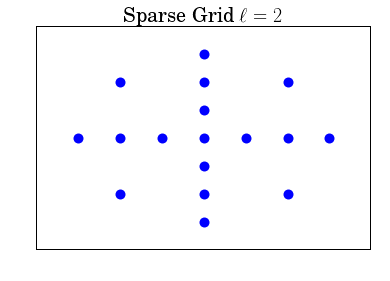

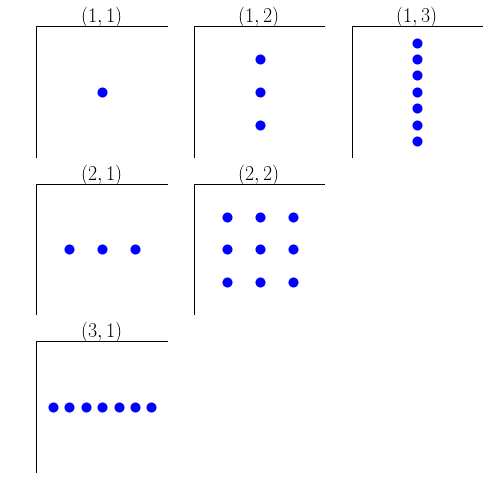

In [10]:
def example7():
    # This time, we use Clenshaw-Curtis points with exponentially growing number of points per level.
    # This is helpful for CC points to make them nested. Nested means that the set of grid points at
    # one level is a subset of the set of grid points at the next level. Nesting can drastically
    # reduce the number of needed function evaluations. Using these grid points, we will do
    # polynomial interpolation at a single point.
    operation = pysgpp.CombigridOperation.createExpUniformLinearInterpolation(2, func)
    # The level manager provides more options for combigrid evaluation, so let's get it:
    levelManager = operation.getLevelManager()
    # We can add regular levels like before:
    maxLevel = 2
    levelManager.addRegularLevels(maxLevel)
    # We can also fetch the used grid points and plot the grid:
    grid = levelManager.getGridPointMatrix()
    gridList = [[grid.get(r, c) for c in range(grid.getNcols())] for r in range(grid.getNrows())]
    def g(x, y):
        evaluationPoint = pysgpp.DataVector([x, y])
        result = operation.evaluate(maxLevel, evaluationPoint)
        return result
    # fig, ax, _ = plotSG3d(grid, alpha)
    # ax.scatter(gridList[0], gridList[1], np.zeros(len(gridList[0])),
    #           color=load_color(0),
    #           marker='o', s=20)
    # ax.set_axis_off()
    # ax.set_xlabel(r"$x$")
    # ax.set_ylabel(r"$y$")
    # ax.set_xticks([0, 0.5, 1])
    # ax.set_yticks([0, 0.5, 1])
    # ax.set_zticks([0, 0.5, 1])
    # ax.xaxis.labelpad = 13
    # ax.yaxis.labelpad = 13
    # ax.set_title(r"$f(x,y) = 16 x(1-x)y(1-y)$",
    #              fontproperties=load_font_properties())
    # savefig(fig, "normal_parabola", mpl3d=True)
    fig = plt.figure()
    plt.plot(gridList[0], gridList[1], " ",
             color=load_color(0),
             marker='o', markersize=10)
    plt.axis('off')
    currentAxis = plt.gca()
    currentAxis.add_patch(Rectangle((0, 0), 1, 1, fill=None, alpha=1, linewidth=2))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.title(r"Sparse Grid $\ell=%i$" % maxLevel,
              fontproperties=load_font_properties())
    # savefig(fig, "/home/franzefn/Desktop/Mario/sparse_grid", mpl3d=True)
    # We can also fetch the used grid points and plot the grid:
    levels = levelManager.getRegularLevels(maxLevel)
    fig, axarr = plt.subplots(maxLevel + 1, maxLevel + 1,
                              sharex=True, sharey=True, squeeze=True)
    for level in product(range(maxLevel + 1), repeat=2):
        ax = axarr[level[0], level[1]]
        ax.axis('off')
    for level in levels:
        ax = axarr[level[0], level[1]]
        h = 2**(-level[0] - 1)
        n = 2 ** (level[0] + 1) - 1
        xs = np.linspace(h, 1 - h, n)
        h = 2 ** (-level[1] - 1)
        n = 2 ** (level[1] + 1) - 1
        ys = np.linspace(h, 1 - h, n)
        xv, yv = np.meshgrid(xs, ys, sparse=False, indexing='xy')
        for i in range(len(xs)):
            for j in range(len(ys)):
                ax.plot(xv[j, i], yv[j, i], color=load_color(0),
                        marker="o", markersize=10)
        ax.set_title(r"$(%i, %i)$" % (level[0] + 1, level[1] + 1),
                     fontproperties=load_font_properties())
        ax.add_patch(Rectangle((0, 0), 1, 1, fill=None, alpha=1, linewidth=1))
    # plt.xlim(0, 1)
    # plt.ylim(0, 1)
    fig.set_size_inches(8, 8, forward=True)
    # savefig(fig, "/home/franzefn/Desktop/Mario/tableau_ct_l%i" % maxLevel,
    #         mpl3d=True)
    
example7()

### Example 8: UQ setting with variance refinement

This example shows how to use the variance refinement method that uses the PCE transformation for variance computation on each subspace. 

In [11]:
def example8(dist_type="uniform"):
    operation = pysgpp.CombigridOperation.createExpClenshawCurtisPolynomialInterpolation(d, func)

    config = pysgpp.OrthogonalPolynomialBasis1DConfiguration()

    if dist_type == "beta":
        config.polyParameters.type_ = pysgpp.OrthogonalPolynomialBasisType_JACOBI
        config.polyParameters.alpha_ = 5
        config.polyParameters.alpha_ = 4

        U = J([Beta(config.polyParameters.alpha_,
                    config.polyParameters.beta_)] * d)
    else:
        config.polyParameters.type_ = pysgpp.OrthogonalPolynomialBasisType_LEGENDRE
        U = J([Uniform(0, 1)] * d)

    basisFunction = pysgpp.OrthogonalPolynomialBasis1D(config)
    basisFunctions = pysgpp.OrthogonalPolynomialBasis1DVector(d, basisFunction)

    q = 3
    operation.getLevelManager().addRegularLevels(q)
    print( "Total function evaluations: %i" % operation.numGridPoints() )
    ## compute variance of the interpolant

    surrogateConfig = pysgpp.CombigridSurrogateModelConfiguration()
    surrogateConfig.type = pysgpp.CombigridSurrogateModelsType_POLYNOMIAL_CHAOS_EXPANSION
    surrogateConfig.loadFromCombigridOperation(operation)
    surrogateConfig.basisFunction = basisFunction
    pce = pysgpp.createCombigridSurrogateModel(surrogateConfig)

    n = 10000
    values = [g(pysgpp.DataVector(xi)) for xi in U.rvs(n)]
    print( "E(u)   = %g ~ %g" % (np.mean(values),
                                pce.mean()))
    print( "Var(u) = %g ~ %g" % (np.var(values),
                                pce.variance()))
    
example8()

Total function evaluations: 29


RuntimeError: need Eigen to use the PCE transformation.